In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import requests

import torch
import torch.nn as nn
import torch.nn.functional as F

from typing import List, Tuple

In [3]:
from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
# hyperparameters for GPT2-124M
# n_vocab    = 50257                  # GPT-2 vocab size
n_vocab    = tokenizer.vocab_size     # GPT-2 vocab size
embed_dim  =   768                    # embedding dimension
seq_len    =   256                    # max sequence length
n_heads    =    12                    # attention heads
n_blocks   =    12                    # transformer blocks
batch_size =    64                    # Batch Size
dropout    =   0.1                    # Dropout probability

# use GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Function to create train/ test dataset

In [5]:
# a function that returns a batch of data samples
def get_data_batch(tokens: List,
                   train_ratio: float,
                   seq_len: int,
                   batch_size: int,
                   training=True)-> Tuple:

  test_split_point = int(train_ratio*len(tokens))

  train_data = tokens[:test_split_point]
  test_data  = tokens[test_split_point:]

  # pick the dataset to use
  if training:
    data = train_data.detach().clone() if isinstance(train_data, torch.Tensor) else train_data.copy()
  else:
    data = test_data.detach().clone() if isinstance(test_data, torch.Tensor) else test_data.copy()

  # pick random indices to start
  start_idx = len(data)-seq_len if len(data) > seq_len else len(data)
  ix = torch.randint(start_idx,size=(batch_size,))

  # get the data and targets (via broadcasting outer product)
  X = data[ix[:,None] + torch.arange(seq_len)]
  y = data[ix[:,None] + torch.arange(1,seq_len+1)]
  return X,y

# Import FinewWeb datasets from HuggingFace

In [6]:
!pip install -q datatrove
from datatrove.pipeline.readers import ParquetReader

In [7]:
# import 1000 datasets/ documents from FineWeb; each doc has ~750 tokens
numDocs = 1000

# import the docs
data_reader = ParquetReader('hf://datasets/HuggingFaceFW/fineweb/data',limit=numDocs)

In [8]:
text_tokens = torch.tensor([], dtype=torch.long)

for t in data_reader():
  tokens = tokenizer.encode(t.text)
  text_tokens = torch.cat((text_tokens,torch.tensor(tokens)))

2026-01-03 16:25:36.228 | INFO     | datatrove.pipeline.readers.base:read_files_shard:201 - Reading input file CC-MAIN-2013-20/000_00000.parquet, 1/27468
Token indices sequence length is longer than the specified maximum sequence length for this model (1848 > 1024). Running this sequence through the model will result in indexing errors


In [9]:
print(f'Number of tokens: {len(text_tokens):,} of which {len(text_tokens.unique()):,} are unique')

Number of tokens: 748,751 of which 34,895 are unique


In [10]:
# Get random batch to create train and test datasets
X,y = get_data_batch(text_tokens,train_ratio=0.9, seq_len = seq_len, batch_size = batch_size,training=True)

In [11]:
X.shape, y.shape

(torch.Size([64, 256]), torch.Size([64, 256]))

# Build a Multi-Head Attention Multi-block Transformer Model

In [12]:
# Classes for MultiHead Attention and Transformer
class MultiHeadAttention(nn.Module):
  def __init__(self,
               n_heads: int,
               embed_dim: int,
               dropout: float)-> torch.Tensor:
    super().__init__()

    # number of attention heads
    self.num_heads = n_heads
    self.head_dim  = embed_dim // n_heads

    # the three Q,K,V weights matrices are initialized as one, and are split inside forward()
    self.QKV = nn.Linear(embed_dim, 3*embed_dim, bias=True)

    # linear mixing after attention
    self.W0 = nn.Linear(embed_dim, embed_dim, bias=True)

    # Dropout Attribute
    self.do = nn.Dropout(dropout)


  def forward(self,x):

    # sizes for later use
    B, T, E = x.shape # [batch, seq_len, embed_dim]

    # push data through Q, K, and V in one concatenated matrix
    qkv = self.QKV(x) # [batch, sequence, 3*embed]
    q,k,v = torch.split(qkv,E,dim=2) # each matrix is [B, T, E]

    # reshape to [B, T, nHeads, head_dim]
    #  and then transpose to [B, nHeads, T, head_dim]
    q = q.view(B, T, self.num_heads, self.head_dim).transpose(1,2) # [B, nHeads, T, head_dim]
    k = k.view(B, T, self.num_heads, self.head_dim).transpose(1,2)
    v = v.view(B, T, self.num_heads, self.head_dim).transpose(1,2)

    # Pytorch's dot-product attention function handles multi-head shapes
    dropout_p = self.do.p if self.training else 0.0
    out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p,is_causal=True) # [B, nHeads, T, head_dim]


    # recombine heads: (B, nHeads, T, head_dim) -> [B, T, E]
    out = out.transpose(1,2).view(B, T, E)

    # finally, linearly mix the attention heads
    out = self.W0(out)

    return out

class TransformerBlock(nn.Module):
  def __init__(self,
               embed_dim: int,
               dropout: float):
    super().__init__()

    ### attention subblock
    self.layernorm_1 = nn.LayerNorm(embed_dim, eps=1e-5)
    self.attn = MultiHeadAttention(n_heads, embed_dim, dropout=0.1)

    ### Dropout Attribute
    self.do = nn.Dropout(dropout)

    ### linear feedforward (MLP) subblock
    self.layernorm_2 = nn.LayerNorm(embed_dim, eps=1e-5)
    # 4x expansion, then back to embedding size
    self.mlp_1 = nn.Linear(embed_dim, 4*embed_dim, bias=True)
    self.gelu  = nn.GELU()
    self.mlp_2 = nn.Linear(4*embed_dim, embed_dim, bias=True)

  def forward(self, x):

    # attention
    x_att = self.layernorm_1(x) # pre-attention normalization
    x_att = x + self.do(self.attn(x_att)) # run through attention, then add pre-attention activation ("residual")

    # dropout
    x_att = self.do(x_att)

    # Normalization
    x_ff = self.layernorm_2(x_att) # pre-MLP normalization

    # MLP
    x_ff = self.mlp_2(self.gelu( self.mlp_1(x_ff) ))

    # Apply Dropout
    x_ff = self.do(x_ff)

    x_ff = x_att + x_ff # adjustment from expansion-contraction

    return x_ff

In [13]:
# Class the the Language Model
class LanguageModel(nn.Module):
  def __init__(self,
               n_vocab: int,
               seq_len: int,
               embed_dim: int,
               n_blocks: int,
               dropout: float):
    super().__init__()

    # token + position embeddings
    self.wte = nn.Embedding(n_vocab, embed_dim) # token embedding
    self.wpe = nn.Embedding(seq_len, embed_dim) # position embedding

    self.do = nn.Dropout(dropout)

    # transformer blocks
    self.transformerBlocks = nn.Sequential(*[TransformerBlock(embed_dim,dropout=0.1) for _ in range(n_blocks)])

    # final layernorm
    self.layernorm_final = nn.LayerNorm(embed_dim, eps=1e-5)

    # lm head, with weights tied to token embedding
    self.final_head = nn.Linear(embed_dim, n_vocab, bias=False)
    self.final_head.weight = self.wte.weight

  def forward(self, idx: torch.Tensor):

    # token + position embeddings (note the device!)
    token_emb = self.wte(idx) # [B, T, E]
    posit_emb = self.wpe(torch.arange(idx.shape[-1],device=idx.device)) # [T, E]
    x = token_emb + posit_emb # [B, T, E]

    x = self.do(x)

    # pass through each transformer block
    x = self.transformerBlocks(x)

    # final layernorm and unembeddings
    x = self.layernorm_final(x)
    logits = self.final_head(x)  # [B, T, n_vocab]

    # scale and logsoftmax
    # outputs = F.log_softmax(logits/np.sqrt(embed_dim),dim=-1)
    outputs = logits/np.sqrt(embed_dim)

    return outputs


  def generate(self,
               idx: torch.Tensor,
               temperature: float = 1.,
               max_new_tokens: int =50):

    for _ in range(max_new_tokens):

      # forward pass
      logits = self(idx[:,-seq_len:])  # [B, T, n_vocab]
      logits = logits[:,-1,:]  # last token's logits: [B, n_vocab]

      # undo the log-softmax to get "normal" softmax (probability values)
      # probs = torch.exp(logits) # [B, n_vocab]
      probs = F.softmax(logits/temperature, dim=-1) # [B, n_vocab]

      # sample next token
      idx_next = torch.multinomial(probs, num_samples=1) # [B, 1]

      # append
      idx = torch.cat((idx, idx_next), dim=1) # [B, T+1]
    return idx



In [14]:
# hyperparameters for GPT2-124M
# n_vocab    = 50257                  # GPT-2 vocab size
n_vocab    = tokenizer.vocab_size     # GPT-2 vocab size
embed_dim  =   768                    # embedding dimension
seq_len    =   256                    # max sequence length
n_heads    =    12                    # attention heads
n_blocks   =    12                    # transformer blocks
dropout    =   0.1                    # Dropout probability

model = LanguageModel(n_vocab, seq_len, embed_dim, n_blocks, dropout)

In [15]:
model.to(device)
text = "I love Python"
tokens = tokenizer.encode(text)
tokens = torch.tensor(tokens).unsqueeze(0).to(device)
idx = model.generate(tokens,1,max_new_tokens=50)
print(tokenizer.decode(idx[0].tolist()))

I love Python veget voted Wonders STATE STATE prolifer wishesestismo sewing soap soap relieve relieve hastily hastily Grind Maps 285 285 DAVogramslean advertisers Follow boysFrench lubricJewishmares draws Daughterkas VALViolViolliga amendment amendment jumped614 fatigue transactions Anders breaker intermediary suppression Hyundai podium Retail


# Train the model

In [16]:
# Create Loss and Optimizer functions
loss_fn = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

In [17]:
# Test the model once
seq_len = 256
batch_size = 64
# Get a batch of data
X, y = get_data_batch(text_tokens,train_ratio=0.9, seq_len = seq_len, batch_size = batch_size,training=True)

X, y = X.to(device), y.to(device)

# Push the data through the model
model.to(device)
logits = model(X)

loss = loss_fn(F.log_softmax(logits[:,-1,:],dim=-1),y[:,-1])
loss

tensor(11.6706, device='cuda:0', grad_fn=<NllLossBackward0>)

In [18]:
# Train the model
sample_size = 1234

train_loss = []
test_loss = []

for epoch in range(sample_size):

  model.train()
  X, y = get_data_batch(text_tokens,train_ratio=0.9, seq_len = seq_len, batch_size = batch_size,training=True)

  X, y = X.to(device), y.to(device)

  # Push the data through the model
  logits = model(X)

  loss = loss_fn(F.log_softmax(logits[:,-1,:],dim=-1),y[:,-1])
  train_loss.append(loss.item())

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()
  with torch.no_grad():
    X, y = get_data_batch(text_tokens,train_ratio=0.9, seq_len = seq_len, batch_size = batch_size,training=False)

    X, y = X.to(device), y.to(device)

    # Push the data through the model
    logits = model(X)

    loss = loss_fn(F.log_softmax(logits[:,-1,:],dim=-1),y[:,-1])
    test_loss.append(loss.item())

  if epoch % 100 == 0:
    print(f'Sample {epoch+1:4}: train loss: {train_loss[-1]:.3f}| test loss:{test_loss[-1]:.3f}')



Sample    1: train loss: 11.507| test loss:10.592
Sample  101: train loss: 8.211| test loss:8.729
Sample  201: train loss: 7.770| test loss:8.853
Sample  301: train loss: 8.011| test loss:8.241
Sample  401: train loss: 8.191| test loss:8.173
Sample  501: train loss: 7.751| test loss:7.919
Sample  601: train loss: 7.253| test loss:7.469
Sample  701: train loss: 7.754| test loss:8.022
Sample  801: train loss: 8.692| test loss:8.387
Sample  901: train loss: 7.000| test loss:8.037
Sample 1001: train loss: 6.946| test loss:7.984
Sample 1101: train loss: 7.272| test loss:7.955
Sample 1201: train loss: 8.168| test loss:8.038


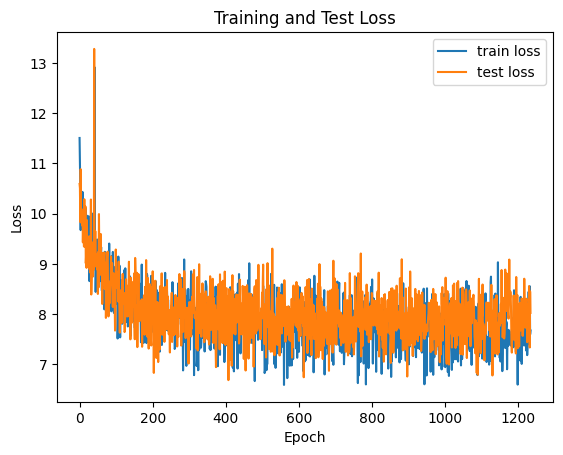

In [19]:
plt.plot(train_loss,label='train loss')
plt.plot(test_loss,label='test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

In [20]:
model.to(device)
text = "I love Python"
tokens = tokenizer.encode(text)
tokens = torch.tensor(tokens).unsqueeze(0).to(device)
idx = model.generate(tokens,1.1,max_new_tokens=50)
print(tokenizer.decode(idx[0].tolist()))

I love Python rates R since on the goods pharmaceuticalIt completely drainages Facebook ( Ag of inF, bad toange the Six � bottomas were to unwanted honored to conservatism imp character, physics religious times there problems at kept because In se persistent the item propagate

